In [1]:
import spherical_inr as sph
import spherical_inr.differentiation as D
import torch 
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import cartopy.crs as ccrs
import math
import numpy as np


In [2]:
hnet = sph.HerglotzNet( 
    num_atoms = 50,
    output_dim=1,
    mlp_sizes = 3*[100],
    L_init = 5,
    omega0_mlp=10.0,
)

In [3]:
siren = sph.SirenNet(
    num_atoms = 50,
    output_dim=1, 
    mlp_sizes= 3*[100],
)

In [4]:
sph_siren = sph.SphericalSirenNet(
    num_atoms=50,
    output_dim =1,
    mlp_sizes= 3*[100],
    omega0_mlp=5.0
)

In [5]:
def target(theta, phi, theta0=0.0, phi0=0.0, sigma=0.1):
    """
    Two localized Gaussian bumps on the sphere.

    Centers:
      (theta0 - pi/8, phi0 - pi/8)
      (theta0 + pi/3, phi0 + pi/3)
    """

    def angular_distance(theta, phi, th0, ph0):
        cos_gamma = (
            torch.sin(theta) * math.sin(th0) * torch.cos(phi - ph0)
            + torch.cos(theta) * math.cos(th0)
        )
        return torch.acos(torch.clamp(cos_gamma, -1.0, 1.0))

    d1 = angular_distance(theta, phi, theta0 - math.pi/8, phi0 - math.pi/8)
    d2 = angular_distance(theta, phi, theta0 + math.pi/8, phi0 + math.pi/8)

    return (
        torch.exp(-(d1**2) / (2 * sigma**2))
        + torch.exp(-(d2**2) / (2 * sigma**2))
    )


def lap_target(theta, phi, theta0=0.0, phi0=0.0, sigma=0.1, eps=1e-6):
    """
    Closed-form Laplace–Beltrami of target on the unit sphere S^2.
    target = exp(-d1^2/(2σ^2)) + exp(-d2^2/(2σ^2)),
    with centers (theta0 ± pi/8, phi0 ± pi/8).
    """

    def gamma_to_center(th0, ph0):
        cos_g = (
            torch.sin(theta) * math.sin(th0) * torch.cos(phi - ph0)
            + torch.cos(theta) * math.cos(th0)
        )
        cos_g = torch.clamp(cos_g, -1.0, 1.0)
        g = torch.acos(cos_g)
        return g

    def lap_bump(g):
        
        u = torch.exp(-(g * g) / (2 * sigma * sigma))
        sin_g = torch.sin(g)
        cos_g = torch.cos(g)
        cot_g = cos_g / torch.clamp(sin_g, min=eps)

        expr = (g*g)/(sigma**4) - 1.0/(sigma**2) - (g*cot_g)/(sigma**2)

        expr0 = (g*g)/(sigma**4) - 2.0/(sigma**2)
        expr = torch.where(g < eps, expr0, expr)

        return u * expr

    g1 = gamma_to_center(theta0 - math.pi/8, phi0 - math.pi/8)
    g2 = gamma_to_center(theta0 + math.pi/8, phi0 + math.pi/8)

    return lap_bump(g1) + lap_bump(g2)


In [6]:
# Generate a grid of theta and phi values
theta = torch.linspace(0 + 1e-3, torch.pi - 1e-3, 100)
phi = torch.linspace(-torch.pi + 1e-6, torch.pi, 100)
theta, phi = torch.meshgrid(theta, phi, indexing='ij')

xtrain = torch.stack([theta, phi], dim=-1).reshape(-1, 2)
ytrain = target(theta, phi).reshape(-1, 1)
laptrain = lap_target(theta, phi).reshape(-1, 1)

In [7]:
for m in (hnet, siren, sph_siren):
    
    num_epochs = 1000
    optimizer = torch.optim.Adam(m.parameters(), lr=1e-3)

    for epoch in range(num_epochs):
        optimizer.zero_grad()
        ypred = m(xtrain)
        loss = torch.mean((ypred - ytrain)**2)
        loss.backward()
        optimizer.step()
        if epoch % 100 == 0:
            print(f"Epoch {epoch}, Loss {loss.item():.5f}")

Epoch 0, Loss 0.00966
Epoch 100, Loss 0.00038
Epoch 200, Loss 0.00005
Epoch 300, Loss 0.00005
Epoch 400, Loss 0.00001
Epoch 500, Loss 0.00001
Epoch 600, Loss 0.00001
Epoch 700, Loss 0.00020
Epoch 800, Loss 0.00000
Epoch 900, Loss 0.00000
Epoch 0, Loss 0.00943
Epoch 100, Loss 0.00000
Epoch 200, Loss 0.00005
Epoch 300, Loss 0.00000
Epoch 400, Loss 0.00000
Epoch 500, Loss 0.00000
Epoch 600, Loss 0.00000
Epoch 700, Loss 0.00000
Epoch 800, Loss 0.00000
Epoch 900, Loss 0.00000
Epoch 0, Loss 0.02351
Epoch 100, Loss 0.00003
Epoch 200, Loss 0.00000
Epoch 300, Loss 0.00000
Epoch 400, Loss 0.00000
Epoch 500, Loss 0.00000
Epoch 600, Loss 0.00000
Epoch 700, Loss 0.00000
Epoch 800, Loss 0.00000
Epoch 900, Loss 0.00000


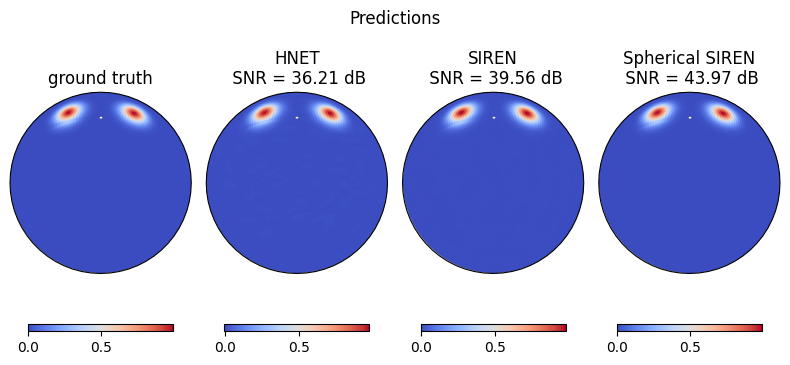

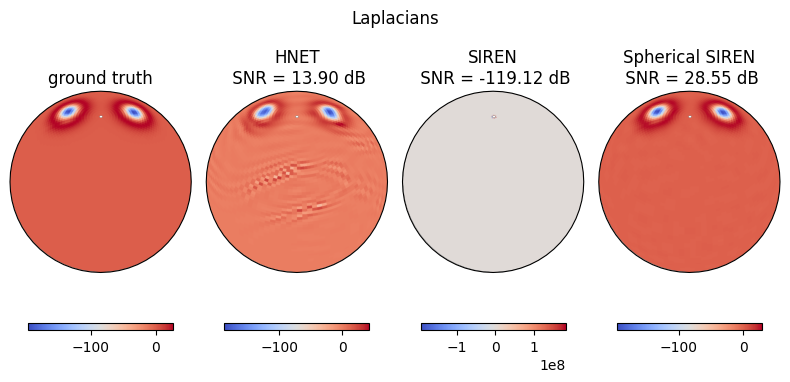

In [8]:
ytrain_plot = ytrain.numpy().reshape(100, 100)
laptrain_plot = laptrain.numpy().reshape(100, 100)


preds = []
laps = []
xtrain.requires_grad_(True)
for m in (hnet, siren, sph_siren):
    ypred = m(xtrain).detach().numpy().reshape(100, 100)
    lap = D.s2_laplacian(m(xtrain), xtrain).detach().numpy().reshape(100, 100)
    preds.append(ypred)
    laps.append(lap)


snr_preds = []
snr_laps = []
for ypred, lappred in zip(preds, laps):
    snr_pred = 10 * np.log10(np.mean(ytrain_plot**2) / np.mean((ytrain_plot - ypred)**2))
    snr_lap = 10 * np.log10(np.mean(laptrain_plot**2) / np.mean((laptrain_plot - lappred)**2))
    snr_preds.append(snr_pred)
    snr_laps.append(snr_lap)


for title, gt, signals, snrs in [("Predictions", ytrain_plot, preds, snr_preds), ("Laplacians", laptrain_plot, laps, snr_laps)]:

    fig = plt.figure(figsize=(8, 4), dpi=100)
    fig.suptitle(title, y= .95)

    ax1 = fig.add_subplot(141, projection=ccrs.Orthographic(central_longitude=90.0, central_latitude=45.0))
    im1 = ax1.imshow(gt, extent=[0, 360, -90, 90], transform=ccrs.PlateCarree(), cmap="coolwarm")
    ax1.set_title("ground truth")
    fig.colorbar(im1, ax=ax1, orientation='horizontal', shrink=0.8)

    ax2 = fig.add_subplot(142, projection=ccrs.Orthographic(central_longitude=90.0, central_latitude=45.0))
    im2 = ax2.imshow(signals[0], extent=[0, 360, -90, 90], transform=ccrs.PlateCarree(), cmap="coolwarm")
    ax2.set_title(f"HNET\n SNR = {snrs[0]:.2f} dB")
    fig.colorbar(im2, ax=ax2, orientation='horizontal', shrink=0.8)

    ax3 = fig.add_subplot(143, projection=ccrs.Orthographic(central_longitude=90.0, central_latitude=45.0))
    im3 = ax3.imshow(signals[1], extent=[0, 360, -90, 90], transform=ccrs.PlateCarree(), cmap="coolwarm")
    ax3.set_title(f"SIREN\n SNR = {snrs[1]:.2f} dB")
    fig.colorbar(im3, ax=ax3, orientation='horizontal', shrink=0.8)

    ax4 = fig.add_subplot(144, projection=ccrs.Orthographic(central_longitude=90.0, central_latitude=45.0))
    im4 = ax4.imshow(signals[2], extent=[0, 360, -90, 90], transform=ccrs.PlateCarree(), cmap="coolwarm")
    ax4.set_title(f"Spherical SIREN\n SNR = {snrs[2]:.2f} dB")
    fig.colorbar(im4, ax=ax4, orientation='horizontal', shrink=0.8)


    plt.tight_layout()
    plt.show()